# EDA for Gas Fees - Proof of workflow. 

In this notebook we perform Exploratory Data Analysis (EDA) on FIL's gas fee mechanism. The goal is to observe the gas fee as a signal and attempt to understand what may be driving it. 

Access was obtained to Sentinel from Filecoin, and based on previous Block Science data work, we believe the the gas information is in the `messages` or `message_gas_economy` tables. **Update**: based on discussion with Filecoin, the `derived_gas_outputs` table is used as the primary data gathering table. [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md) was obtained on 6/28/2021 and will drive subsquent analysis. 

## What are Gas Fees? 
Note: this description is copied from the [official Filecoin documentation](https://docs.filecoin.io/about-filecoin/how-filecoin-works/#gas-fees)

Executing messages, for example by including transactions or proofs in the chain, consumes both computation and storage resources on the network. Gas is a measure of resources consumed by messages. The gas consumed by a message directly affects the cost that the sender has to pay for it to be included in a new block by a miner.

Historically in other blockchains, miners specify a GasFee in a unit of native currency and then pay the block producing miners a priority fee based on how much gas is consumed by the message. Filecoin works similarly, except an amount of the fees is burned (sent to an irrecoverable address) to compensate for the network expenditure of resources, since all nodes need to validate the messages. The idea is based on Ethereum's EIP1559.

The amount of fees burned in the Filecoin network comes given by a dynamic BaseFee which gets automatically adjusted according to the network congestion parameters (block sizes). The current value can be obtained from one of the block explorers or by inspecting the current head.

Additionally, a number of gas-related parameters are attached to each message and determine the amount of rewards that miners get. Here's an overview of the terms and concepts:

**GasUsage**: the amount of gas that a message's execution actually consumes. Current protocol does not know how much gas a message will exactly consume ahead of execution, but it can be estimated (see prices (opens new window)). GasUsage measured in units of Gas.

**BaseFee**: the amount of FIL that gets burned per unit of gas consumed for the execution of every message. It is measured in units of attoFIL/Gas.

**GasLimit**: the limit on the amount of gas that a message's execution can consume, estimated and specified by a message sender. It is measured in units of Gas. The sum of GasLimit for all messages included in a block must not exceed the BlockGasLimit. Messages will fail to execute if they run out of Gas, and any effects of the execution will be reverted.

**GasFeeCap**: the maximum token amount that a sender is willing to pay per GasUnit for including a message in a block. It is measured in units of attoFIL/Gas. A message sender must have a minimum balance of GasFeeCap * GasLimit when sending a message, even though not all of that will be consumed. GasFeeCap can serve as a safeguard against high, unexpected BaseFee fluctuations.

**GasPremium**: a priority fee that is paid to the block-producing miner. This is capped by GasFeeCap. The BaseFee has a higher priority. It is measured in units of attoFIL/Gas and can be as low as 1 attoFIL/Gas.

**Overestimation burn**: an additional amount of gas to burn that grows larger when the difference between GasLimit and GasUsage is large. 

The total cost of a message for a sender will be:

* GasUsage * BaseFee FIL (burned) +
* GasLimit * GasPremium FIL (miner's reward) +
* OverEstimationBurn * BaseFee FIL

An important detail is that a message will always pay the burn fee, regardless of the GasFeeCap used. Thus, a low GasFeeCap may result in a reduced GasPremium or even a negative one! In that case, the miners that include a message will have to pay the needed amounts out of their own pockets, which means they are unlikely to include such messages in new blocks.

Filecoin implementations may choose the heuristics of how their miners select messages for inclusion in new blocks, but they will usually attempt to maximize the miner's rewards.


## Data Resources
* https://hackmd.io/5leND7tITX--5NJsFCJyow # Existing Sentinel queries 
* https://github.com/filecoin-project/sentinel/blob/master/docs/sentinel_tables_purpose.csv # Sentinel Tables Purpose


### Sentinel Diagram 
![](sentinel_diagram.png)

## Analysis

We are performing a vector autoregression (VAR) to determine if a casual or multi-causal relationship exists between the gas signals moves. This will help us understand the system-level dynamics of Filecoin.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univariate autoregression models allowing for multivariate time series analysis.

Autoregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccurring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$

For our VAR model, we will have a vector of gas signals.

#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differencing can be used to make the data stationary.
* Data is on the same scale
* Time sampling is consistent 

### Other methods with fewer assumptions

Non-parametric Bayesian VAR models have been under development and appear to perform well and can operate on nonlinear relationships, heteroscedasticity, and non-Gaussian error data[1,2].

Another popular time series analysis modeling technique is the Autoregressive Integrated Moving Average (ARIMA) model. These models are often used in forecasting or when the data shows evidence of non-stationarity. For multiple time series vectors, as we have here, extensions of the ARIMA model are available, such ARIMAX model that has exogenous variable inputs. ARIMAX models do not have an assumption of Gaussian errors as it uses a maximum likelihood estimation function to fit.

#### References
- 1 Kalli, Maria & Griffin, Jim E., 2018. "Bayesian nonparametric vector autoregressive models," Journal of Econometrics, Elsevier, vol. 203(2), pages 267-282.
- 2 Jeliazkov, Ivan. (2013). Nonparametric Vector Autoregressions: Specification, Estimation, and Inference. Advances in Econometrics. 33. 10.1108/S0731-9053(2013)0000031009. 


We have taken the trade-off in assumption for this first version correlation model vs a non-parametric approach for simplicity's sake, that current robust python VAR implementations exist, and for illustrative purposes around the concepts, we are addressing.


In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [2]:
# load connection string
CONN_STRING_PATH = 'sentinel_conn_string_andrew.txt'

with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()


## Data EDA

Below we download hourly averages from the `derived_gas_outputs` table from May 1st, 2021 to present (last refreshed 6/28/2021). After downloading the data, we few the first and lasts 5 rows, and perform basic statistics on the data.


### `derived_gas_outputs` - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)
Derived gas costs resulting from execution of a message in the VM.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`actor_name`|`text`|NO|Human readable identifier for the type of the actor.|
|`base_fee_burn`|`text`|NO|The amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.|
|`cid`|`text`|NO|CID of the message.|
|`exit_code`|`bigint`|NO|The exit code that was returned as a result of executing the message. Exit code 0 indicates success. Codes 0-15 are reserved for use by the runtime. Codes 16-31 are common codes shared by different actors. Codes 32+ are actor specific.|
|`from`|`text`|NO|Address of actor that sent the message.|
|`gas_burned`|`bigint`|NO|The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|YES|A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`gas_refund`|`bigint`|NO|The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.|
|`gas_used`|`bigint`|NO|A measure of the amount of resources (or units of gas) consumed, in order to execute a message.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number to invoke. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`miner_penalty`|`text`|NO|Any penalty fees (in attoFIL) the miner incured while executing the message.|
|`miner_tip`|`text`|NO|The amount of FIL (in attoFIL) the miner receives for executing the message. Typically it is gas_premium * gas_limit but may be lower if the total fees exceed the gas_fee_cap.|
|`nonce`|`bigint`|YES|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`over_estimation_burn`|`text`|NO|The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee.|
|`parent_base_fee`|`text`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`refund`|`text`|NO|The amount of FIL (in attoFIL) to refund to the message sender after base fee, miner tip and overestimation amounts have been deducted.|
|`size_bytes`|`bigint`|YES|Size in bytes of the serialized message.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`to`|`text`|NO|Address of actor that received the message.|
|`value`|`text`|NO|The FIL value transferred (attoFIL) to the message receiver.|




In [3]:
QUERY = """
SELECT 
date_trunc('hour', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) > '2021-05-01'
GROUP BY
timestamp
"""
derived_gas_outputs = (pd.read_sql(QUERY, connection))

In [4]:
derived_gas_outputs.head()

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-05-01 00:00:00+00:00,1.560131e+10,1.482218e+07,4.400210e+07,3.544539e+07,3.287172e+09,1.142042e+17,7.885100e+15,6.147325e+06,2.409388e+06
1,2021-05-01 01:00:00+00:00,1.325130e+10,1.038786e+07,4.374094e+07,3.516687e+07,2.875746e+09,9.864674e+16,7.128347e+15,6.033203e+06,2.540860e+06
2,2021-05-01 02:00:00+00:00,1.566131e+10,6.501496e+06,4.007360e+07,3.235859e+07,3.391013e+09,1.073700e+17,6.432014e+15,5.813149e+06,1.901862e+06
3,2021-05-01 03:00:00+00:00,1.295362e+10,7.830208e+06,4.310044e+07,3.467378e+07,2.724790e+09,9.247733e+16,6.693012e+15,5.940040e+06,2.486627e+06
4,2021-05-01 04:00:00+00:00,1.392573e+10,9.203523e+06,4.091478e+07,3.288442e+07,2.757795e+09,8.882479e+16,6.161389e+15,5.792842e+06,2.237511e+06


In [5]:
derived_gas_outputs.tail()

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
1337,2021-06-25 17:00:00+00:00,5.020299e+09,315874.316104,3.753990e+07,3.066023e+07,1.170075e+08,3.518761e+15,1.555417e+14,5.538000e+06,1.341666e+06
1338,2021-06-25 18:00:00+00:00,4.528957e+09,118026.606812,3.656435e+07,2.990070e+07,5.534192e+07,1.623433e+15,7.071735e+13,5.394168e+06,1.269488e+06
1339,2021-06-25 19:00:00+00:00,5.014644e+09,254320.472354,3.839476e+07,3.119200e+07,1.049332e+08,3.243115e+15,1.642748e+14,5.682264e+06,1.520495e+06
1340,2021-06-25 20:00:00+00:00,6.315006e+09,247058.814685,3.904219e+07,3.176776e+07,2.675574e+08,8.360973e+15,4.108243e+14,5.749173e+06,1.525257e+06
1341,2021-06-25 21:00:00+00:00,5.657777e+09,470410.314271,3.879011e+07,3.171930e+07,1.737686e+08,5.427558e+15,2.338489e+14,5.730747e+06,1.340059e+06


In [6]:
derived_gas_outputs.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
count,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03,1.342000e+03
mean,8.922672e+09,2.291130e+06,3.994873e+07,3.244743e+07,9.222688e+08,2.966535e+16,1.666373e+15,5.783734e+06,1.717571e+06
std,3.900477e+09,3.042393e+06,1.872213e+06,1.117551e+06,8.559667e+08,2.781802e+16,1.694872e+15,2.282593e+05,1.304658e+06
min,1.401976e+09,1.010942e+05,3.511228e+07,2.811138e+07,1.016643e+02,2.964737e+09,1.218508e+08,4.851994e+06,1.068593e+06
25%,5.712867e+09,3.229073e+05,3.889298e+07,3.170565e+07,2.365683e+08,7.542218e+15,3.556347e+14,5.635584e+06,1.447565e+06
50%,9.219596e+09,1.143213e+06,3.979790e+07,3.239524e+07,7.221332e+08,2.288581e+16,1.204481e+15,5.775482e+06,1.627643e+06
75%,1.190024e+10,3.023696e+06,4.089810e+07,3.314708e+07,1.222380e+09,3.874695e+16,2.131599e+15,5.942185e+06,1.820102e+06
max,2.352814e+10,3.093223e+07,7.809493e+07,3.595985e+07,4.889421e+09,1.609283e+17,8.616813e+15,6.683911e+06,4.397566e+07


We will plot each signal, save for the timestamp, below:

 The maximum price that the message sender is willing to pay per unit of gas


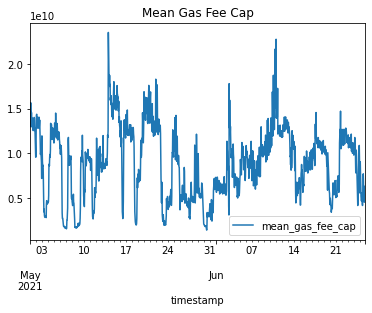

In [32]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_fee_cap',kind='line',title='Mean Gas Fee Cap')
print('The maximum price that the message sender is willing to pay per unit of gas')

The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.


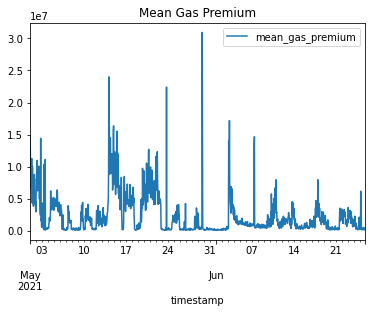

In [33]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_premium',kind='line',title='Mean Gas Premium')
print('The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.')

A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.


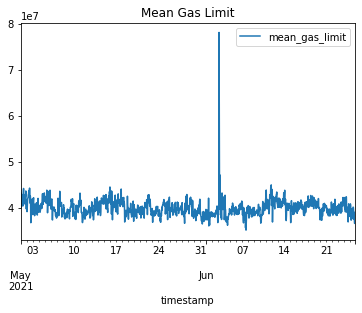

In [34]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_limit',kind='line',title='Mean Gas Limit')
print('A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.')

A measure of the amount of resources (or units of gas) consumed, in order to execute a message.


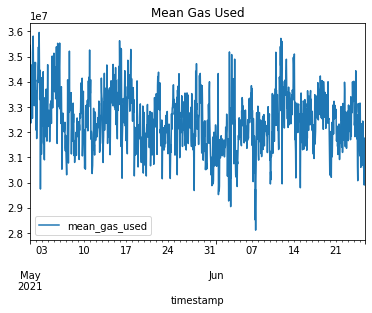

In [35]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_used',kind='line',title='Mean Gas Used')
print('A measure of the amount of resources (or units of gas) consumed, in order to execute a message.')

he set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.


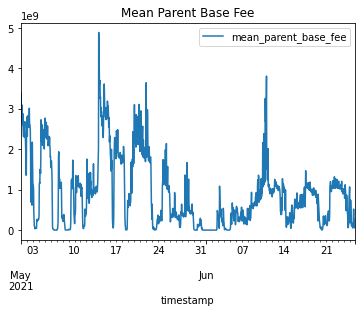

In [36]:
derived_gas_outputs.plot(x='timestamp',y='mean_parent_base_fee',kind='line',title='Mean Parent Base Fee')
print('he set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.')

he amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.


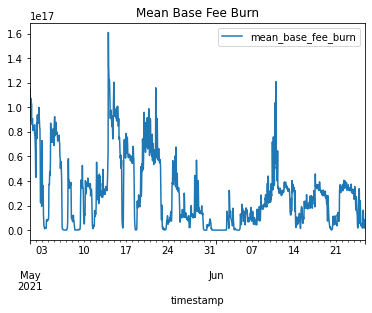

In [37]:
derived_gas_outputs.plot(x='timestamp',y='mean_base_fee_burn',kind='line',title='Mean Base Fee Burn')
print('he amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.')

The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.


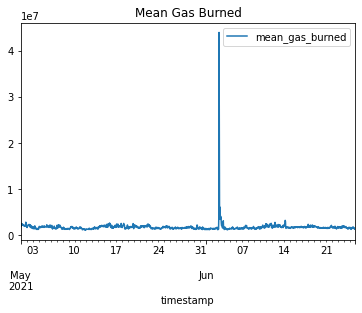

In [40]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_burned',kind='line',title='Mean Gas Burned')
print('The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.')

The data is a relatively consistent, stochastic trend save for several orders of magnitude spike one June 3rd. Mean_gas_burned shows the spike in gas burned the best, with mean_gas_burned being the hourly average of the overestimated units of gas. We will need to examine the meta-information from the messages to understand in more detail to understand why the spike occured. This will also mean querying disaggregated data to understand who the actors are and what transactions they are making.

The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee


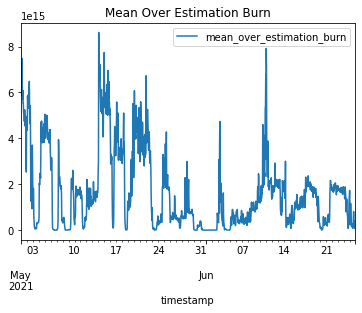

In [38]:
derived_gas_outputs.plot(x='timestamp',y='mean_over_estimation_burn',kind='line',title='Mean Over Estimation Burn')
print('The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee')

The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.


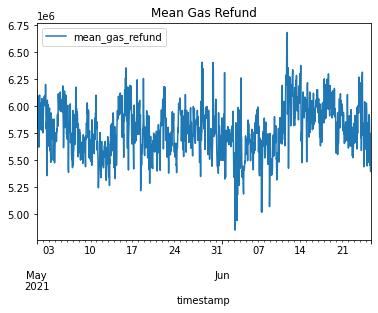

In [39]:
derived_gas_outputs.plot(x='timestamp',y='mean_gas_refund',kind='line',title='Mean Gas Refund')
print('The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.')

In [8]:
derived_gas_outputs.query('mean_gas_burned > 4000000')

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
795,2021-06-03 03:00:00+00:00,4.101927e+09,1.398642e+07,7.809493e+07,2.926728e+07,6.466881e+07,1.815174e+15,3.079097e+15,4.851994e+06,4.397566e+07
796,2021-06-03 04:00:00+00:00,3.096350e+09,9.181094e+06,5.600891e+07,3.113978e+07,4.549856e+07,1.366301e+15,7.491868e+14,4.988144e+06,1.988099e+07
798,2021-06-03 06:00:00+00:00,1.283277e+10,1.718752e+07,4.712814e+07,3.518629e+07,8.726729e+08,3.021975e+16,4.739215e+15,5.846984e+06,6.094867e+06
799,2021-06-03 07:00:00+00:00,1.594804e+10,7.254430e+06,4.227274e+07,3.224065e+07,6.913273e+08,2.202691e+16,2.747635e+15,5.512047e+06,4.520038e+06
802,2021-06-03 10:00:00+00:00,1.300655e+10,3.993850e+06,4.066726e+07,3.136578e+07,5.078446e+08,1.554188e+16,2.050818e+15,5.254736e+06,4.046744e+06


In [49]:
QUERY = """
SELECT
date_trunc('hour', to_timestamp(height_to_unix(d.height))) AS timestamp,
d.actor_name,
d.from,
d.method,
d.to,
d.exit_code
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) = '2021-06-03'
"""
derived_gas_outputs_non_aggregated = (pd.read_sql(QUERY, connection))

### Messages calculation mapping

Based on the message cost calculation outliend by Filecoin's official documentation, we will map the data obtained to this calculation.

Filecoin:
`message_cost_calculation =  GasUsage * BaseFee FIL (burned) + GasLimit * GasPremium FIL (miner reward) + OverEstimationBurn * BaseFee FIL`


Our downloaded data:
`message_cost = derived_gas_outputs.mean_gas_used * derived_gas_outputs.mean_base_fee_burn + derived_gas_outputs.mean_gas_limit * derived_gas_outputs.mean_gas_premium + derived_gas_outputs.mean_over_estimation_burn * derived_gas_outputs.mean_base_fee_burn`

In [9]:
# create field
derived_gas_outputs['mean_message_cost'] = derived_gas_outputs.mean_gas_used * derived_gas_outputs.mean_base_fee_burn + derived_gas_outputs.mean_gas_limit * derived_gas_outputs.mean_gas_premium + derived_gas_outputs.mean_over_estimation_burn * derived_gas_outputs.mean_base_fee_burn

<AxesSubplot:title={'center':'Mean Message Cost'}, xlabel='timestamp'>

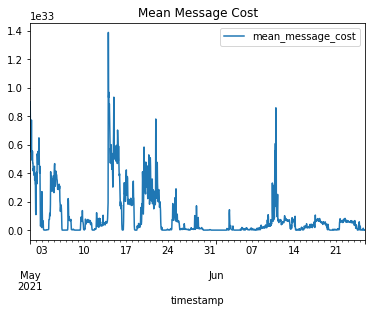

In [10]:
derived_gas_outputs.plot(x='timestamp',y='mean_message_cost',kind='line',title='Mean Message Cost')

### Data processing

We will now remove the timestamp field and examine the data distributions and determine if any transformations are required prior to our VAR modeling.

In [11]:
timestamps = derived_gas_outputs.timestamp
del derived_gas_outputs['timestamp']

array([[<AxesSubplot:title={'center':'mean_gas_fee_cap'}>,
        <AxesSubplot:title={'center':'mean_gas_premium'}>,
        <AxesSubplot:title={'center':'mean_gas_limit'}>],
       [<AxesSubplot:title={'center':'mean_gas_used'}>,
        <AxesSubplot:title={'center':'mean_parent_base_fee'}>,
        <AxesSubplot:title={'center':'mean_base_fee_burn'}>],
       [<AxesSubplot:title={'center':'mean_over_estimation_burn'}>,
        <AxesSubplot:title={'center':'mean_gas_refund'}>,
        <AxesSubplot:title={'center':'mean_gas_burned'}>],
       [<AxesSubplot:title={'center':'mean_message_cost'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

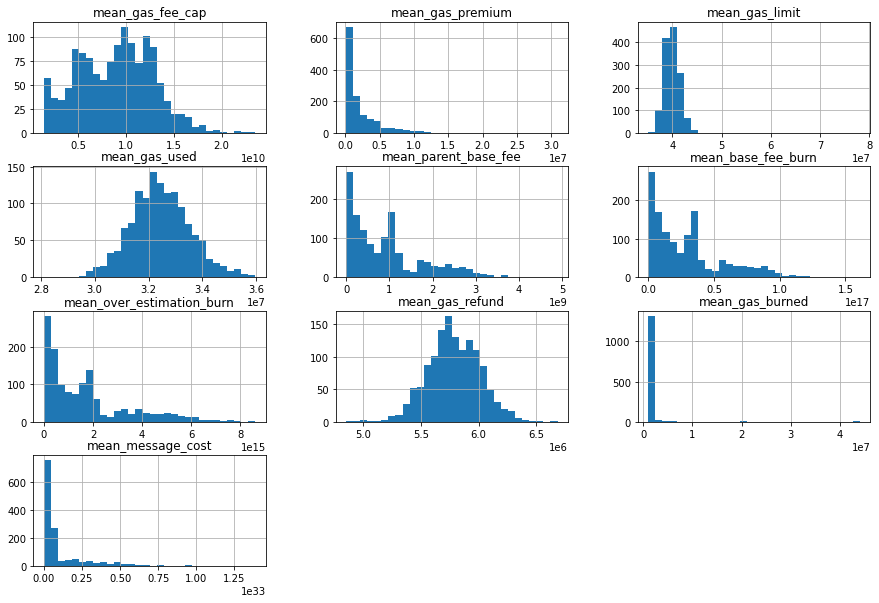

In [12]:
derived_gas_outputs.hist(bins=30, figsize=(15, 10))

We can see from the above historgrams that besides `mean_gas_used` and `mean_gas_refund` our data is not normally distributed and will need to be transformed prior to modeling. We will take the log of the data to reduce the skewness and take the first difference to make the data stationary. 

In [13]:
log_differenced = pd.DataFrame()
## Difference and log values
for i in derived_gas_outputs.columns:
    log_differenced[i +'_log_differenced'] = np.log(derived_gas_outputs[i]).diff()

array([[<AxesSubplot:title={'center':'mean_gas_fee_cap_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_gas_premium_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_gas_limit_log_differenced'}>],
       [<AxesSubplot:title={'center':'mean_gas_used_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_parent_base_fee_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_base_fee_burn_log_differenced'}>],
       [<AxesSubplot:title={'center':'mean_over_estimation_burn_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_gas_refund_log_differenced'}>,
        <AxesSubplot:title={'center':'mean_gas_burned_log_differenced'}>],
       [<AxesSubplot:title={'center':'mean_message_cost_log_differenced'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

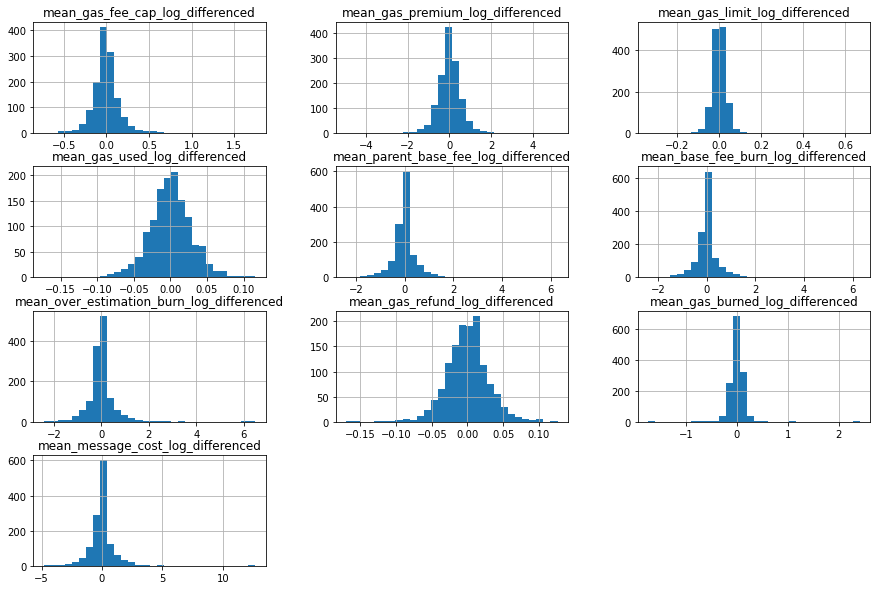

In [14]:
log_differenced.hist(bins=30, figsize=(15, 10))

<!-- ### Data Transformations

We will take the log of the data to reduce the skewness and take the first difference to make the data stationary, meaning that the distribution does not change when shifted by tie. -->

In [15]:
# replace any NA values with zero
log_differenced.dropna(inplace=True)

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [16]:
for i in log_differenced.columns:
    print(i)
    result = adfuller(log_differenced[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

mean_gas_fee_cap_log_differenced
ADF Statistic: -27.512493
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_premium_log_differenced
ADF Statistic: -23.397141
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_limit_log_differenced
ADF Statistic: -13.340761
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_used_log_differenced
ADF Statistic: -12.502743
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_parent_base_fee_log_differenced
ADF Statistic: -17.401780
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_base_fee_burn_log_differenced
ADF Statistic: -14.266826
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_over_estimation_burn_log_differenced
ADF Statistic: -16.317868
p-value: 0.000000
reject, no unit root present
----------------------------------
mea

Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Model Fit

To determine the ideal number of lags for our model, we will perform a heuristic SVD. We will fit our model with an autocorrelation between 1 and 15 to ascertain which VAR order has the best Akaike information criterion(AIC) score.

The **Akaike information criterion (AIC)** is an estimator of prediction error, rooted in information theory. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models as a means for model selection.

When a statistical model is used to represent the process that generated the data, the representation will rarely be exact; so some information will be lost by using the model to represent the process. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.

Below is the equation for AIC where $\hat L$ is the maximum value of the likelihood function for the model: 

$$\mathrm{AIC} \, = \, 2k - 2\ln(\hat L)$$

Given a set of candidate models for the data, the **preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for the goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting.

<!-- The **Bayesian information criterion (BIC)** is a statistical method for model selection among a group of models; **the model with the lowest BIC is preferred, the sign of the data does not matter**. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC).

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.

$$\mathrm{BIC} = k\ln(n) - 2\ln(\widehat L)$$
where
$\hat L$ = the maximized value of the likelihood function of the model $M$
$x$ = the observed data;
$n$ = the number of data points in $x$, 
$k$ = the number of parameters estimated by the model. 


Several researchers that have studied the two metrics argue that BIC is appropriate for selecting the "true model" (i.e. the process that generated the data) from the set of candidate models, whereas AIC choices the best model amongst the alternatives. Proponents of AIC argue that this issue is negligible because the "true model" is virtually never in the candidate set. For our use cases, we will optimize for the AIC as we know the "true" model of the signal behavior is way too complex to be captured within a VAR model.
 -->
Paraphrased sources:
* https://en.wikipedia.org/wiki/Akaike_information_criterion
<!-- * https://en.wikipedia.org/wiki/Bayesian_information_criterion -->

In [17]:
aic = []
for i in range(1,16):
    model = VAR(log_differenced)
    results = model.fit(i)
    aic.append(results.aic)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

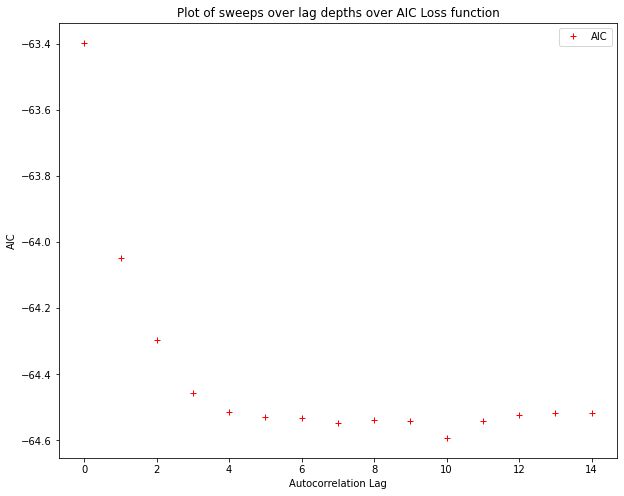

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss function')
plt.show()

Based on our analysis, a lag of 4 appears to be the optimal.

In [19]:
# instantiate the var model object from statsmodels
model = VAR(log_differenced)

# fit model with determined lag values
results = model.fit(4)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [20]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Jun, 2021
Time:                     14:06:04
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -62.8636
Nobs:                     1337.00    HQIC:                  -63.8604
Log likelihood:           24528.7    FPE:                1.01503e-28
AIC:                     -64.4577    Det(Omega_mle):     7.50417e-29
--------------------------------------------------------------------
Results for equation mean_gas_fee_cap_log_differenced
                                                  coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------
const                                               -0.000442         0.003950           -0.112           0.911
L1.mean_gas_fee_cap_l

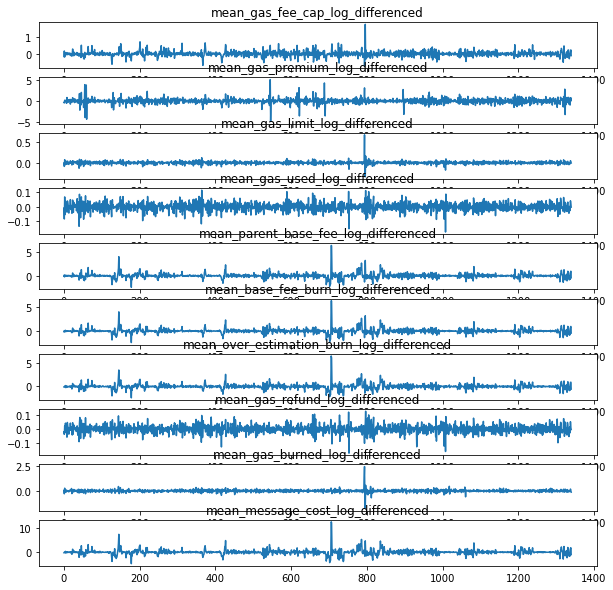

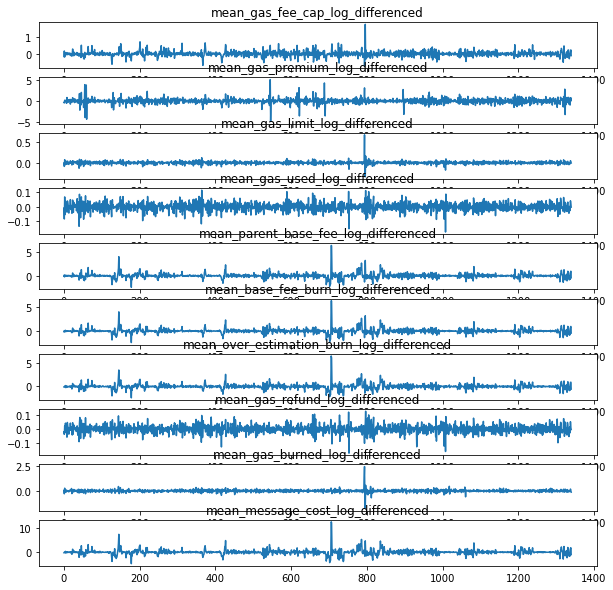

In [21]:
results.plot()

## Granger causality

Granger causality is a hypothesis test for determining whether one-time series is useful in forecasting another. We can say that a variable X, or variables, evolves Granger-causes another evolving variable Y if predictions of the value of Y based on its past values and the past values of X are better than predictions of Y based only on Y's past values. 

Granger Causality is relationship based on the following principles:

* The cause happens before its effect.
* The cause has 'unique' information about the future values of its effect.


Given these two assumptions about causality, Granger proposed to test the following hypothesis for identification of a causal effect of $X$ on $Y$:
$${P}[Y(t+1) \in A\mid \mathcal{I}(t)] \neq \mathbb{P}[Y(t+1) \in A\mid \mathcal{I}_{-X}(t)]$$
where $\mathbb{P}$ refers to probability, $A$ is an arbitrary non-empty set, and $\mathcal{I}(t)$ and $\mathcal{I}_{-X}(t)$ respectively denote the information available as of time $t$ in the entire universe, and that in the modified universe in which $X$ is excluded. If the above hypothesis is accepted, we say that $X$ Granger causes $Y$.

In our analysis, we present the hypothesis that gas_used is a driver of message cost. In statistical parlance, we have the following:

* $H_O: \textrm{Gas used does not Granger cause message cost}$
* $H_A: \textrm{Gas used does Granger cause message cost}$


Granger Causality assumes that the time series are non-stationary, which we checked and passed above, and autoregressive lags greater than 1.

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the gas used has any casual component for predicting the message cost. If the p-value (the probability of obtaining test results at least as extreme as the results observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that gas used is a driver of message cost.

### Paraphrased source:
* https://en.wikipedia.org/wiki/Granger_causality

As we have many signals with the analysis, we will loop through all the signals, perform the Granger Causality test, and save the results for analysis.

In [22]:
alpha = 0.05
result_dfs = []
variables = list(log_differenced.columns)
for i in variables:
    for j in variables:
        if i==j:
            pass
        else:
            results_summary = results.test_causality(i,j, 
                                                     kind='f',signif=alpha).summary()


            df = pd.read_html(results_summary.as_html(),header=0, index_col=0)[0]
            df['alpha'] = alpha
            df['caused'] = i
            df['causing'] = j
            result_dfs.append(df)
        
Grangers_df = pd.concat(result_dfs)
Grangers_df.reset_index(inplace=True)
Grangers_df['result'] = Grangers_df['p-value'].apply(lambda x: 'reject H0' if x < alpha else 'fail to reject H0' )
Grangers_df



,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,0.6569,2.373,0.622,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_premium_log_differenced,fail to reject H0
1,20.5000,2.373,0.000,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_limit_log_differenced,reject H0
2,1.7600,2.373,0.134,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_used_log_differenced,fail to reject H0
3,0.4144,2.373,0.798,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_parent_base_fee_log_differenced,fail to reject H0
4,0.3121,2.373,0.870,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_base_fee_burn_log_differenced,fail to reject H0
...,...,...,...,...,...,...,...,...
85,0.4789,2.373,0.751,"(4, 12960)",0.05,mean_message_cost_log_differenced,mean_parent_base_fee_log_differenced,fail to reject H0
86,3.1720,2.373,0.013,"(4, 12960)",0.05,mean_message_cost_log_differenced,mean_base_fee_burn_log_differenced,reject H0
87,4.1780,2.373,0.002,"(4, 12960)",0.05,mean_message_cost_log_differenced,mean_over_estimation_burn_log_differenced,reject H0
88,6.0840,2.373,0.000,"(4, 12960)",0.05,mean_message_cost_log_differenced,mean_gas_refund_log_differenced,reject H0


Text(0.5, 0.98, 'Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')

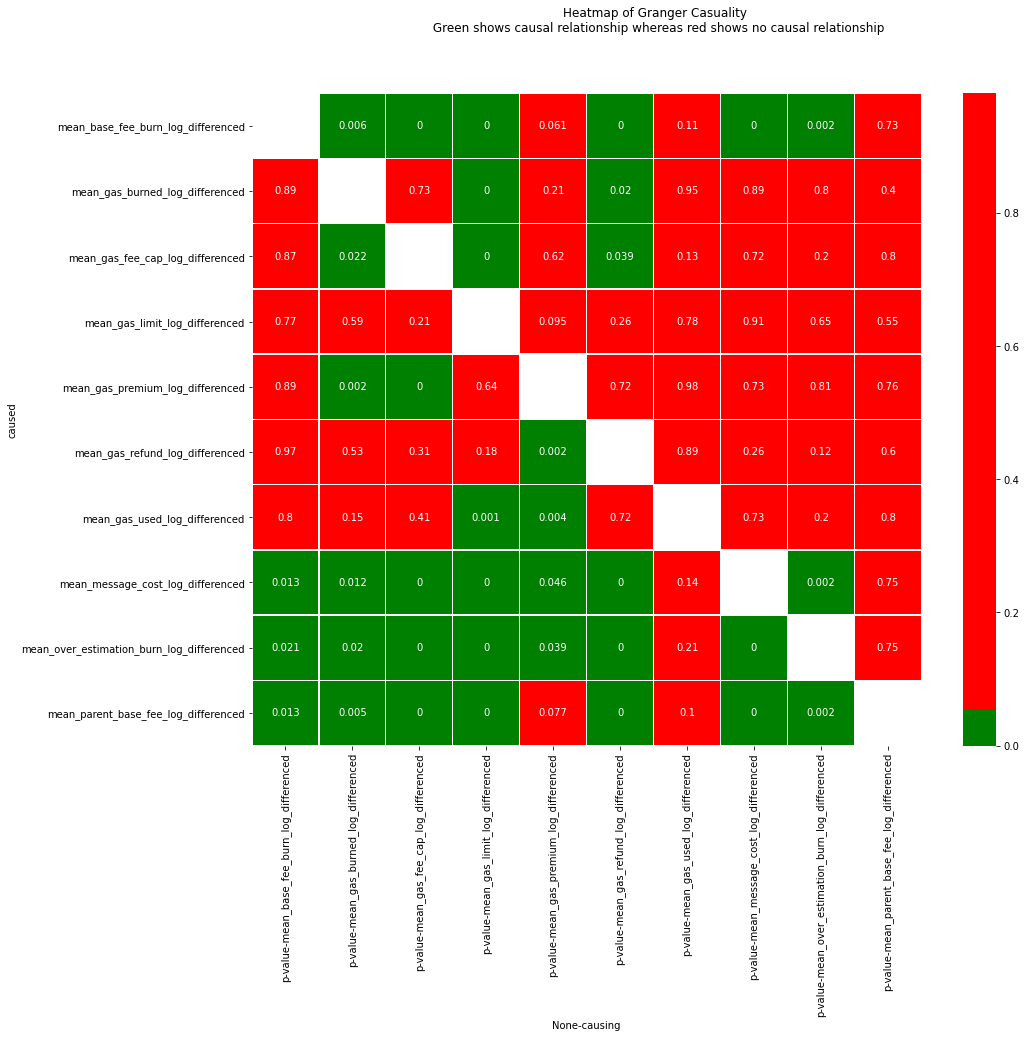

In [23]:
heatdf = Grangers_df.pivot(index='caused', columns=['causing'],values=['p-value'])

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heatdf, annot=True, linewidths=.5, ax=ax,cmap=['green','red'],center=0.05)
plt.suptitle('Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')



Based on the heatmap above, we can see that there are some granger causal relationships between signals. To see more granular specifics, we will examine the reject H0s below

In [24]:
Grangers_df.query("result == 'reject H0'").sort_values('p-value',ascending=True)

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
1,20.500,2.373,0.000,"(4, 12960)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_limit_log_differenced,reject H0
56,9.713,2.373,0.000,"(4, 12960)",0.05,mean_over_estimation_burn_log_differenced,mean_gas_limit_log_differenced,reject H0
74,10.200,2.373,0.000,"(4, 12960)",0.05,mean_gas_burned_log_differenced,mean_gas_limit_log_differenced,reject H0
54,24.740,2.373,0.000,"(4, 12960)",0.05,mean_over_estimation_burn_log_differenced,mean_gas_fee_cap_log_differenced,reject H0
53,7.002,2.373,0.000,"(4, 12960)",0.05,mean_base_fee_burn_log_differenced,mean_message_cost_log_differenced,reject H0
88,6.084,2.373,0.000,"(4, 12960)",0.05,mean_message_cost_log_differenced,mean_gas_refund_log_differenced,reject H0
51,7.008,2.373,0.000,"(4, 12960)",0.05,mean_base_fee_burn_log_differenced,mean_gas_refund_log_differenced,reject H0
47,12.340,2.373,0.000,"(4, 12960)",0.05,mean_base_fee_burn_log_differenced,mean_gas_limit_log_differenced,reject H0
45,29.820,2.373,0.000,"(4, 12960)",0.05,mean_base_fee_burn_log_differenced,mean_gas_fee_cap_log_differenced,reject H0
44,7.009,2.373,0.000,"(4, 12960)",0.05,mean_parent_base_fee_log_differenced,mean_message_cost_log_differenced,reject H0


Based on the above table, we can see some Granger caused relationships between signals, such as mean_gas_fee_cap Granger causes mean_gas_limit. We can't fully use Granger until we understand what the signals are and what they represent better.

## Conclusion 
In this notebook, we've provided proof of workflow for using VAR and Granger Causality to analyze the relationships between variables. In a subsequent notebook, we will examine the gas data more deeply to answer the following questions to use gained insight to improve Filecoin:

* Understand data we have by performing a data baseline - event and aggregated data.
* Reverse engineer June 3 spike - what happened and why? Can we generalize what drives burning?
* Distribution of attributes of things people are willing to pay gas fees for. What types of transactions are individuals paying more for?
* Are revenues over cost?
* Create curated data signals for Digital Twin use
* Obtain message metadata, try and predict cost from it (classifier or regressor). Which attributes are mapped to smaller or larger costs? Which messages are worth paying a lot for? The question is what people are they paying for and *why*?
* Reperform Granger Causality when we have more data understanding

### Next steps from Filecoin sync:
* ZX next steps: Spikes in burn and base fee movement might be a lag. What is the leading indicator?
* Take different data aggregations instead of hourly. One week of data at 30 secs, for instance. 
* Look at a combination of messages.
* From ZX: bad configuration file not from the code but a miner. Spamming the chain on June 3rd, a protective mechanism protects the chain
* Explore weekly spikes - FT for periodic trend
* Check for time-varying volatility. Compare to message types
* Introduce exogenous variables such as delta network power (chain_powers, chain_economics, chain_rewards). Use state root and parent state root to combine, height if not available

